# Visión Artificial con Redes Convolucionales

## Sección 2 - Proyecto (6) - Equipo #4 (T6)
- Alejandro Molina
- Sandro Portanova
- Carlos Fornari

La red implementada en este proyecto es para clasificar imagenes del conjunto de datos "kmnist"

In [17]:
import requests
from keras import layers, models, losses
import numpy as np
from tqdm import tqdm
from keras_tuner import RandomSearch, HyperModel
from matplotlib import pyplot as plt
from shutil import rmtree

# Cargar el dataset KMINST

In [4]:
# Download a list of files
def download_list(url_list):
    for url in url_list:
        path = url.split("/")[-1]
        r = requests.get(url, stream=True)
        with open(path, "wb") as f:
            total_length = int(r.headers.get("content-length"))
            print("Descargando {} - {:.1f} MB".format(path, (total_length / 1024000)))

            for chunk in tqdm(
                r.iter_content(chunk_size=1024),
                total=int(total_length / 1024) + 1,
                unit="KB",
            ):
                if chunk:
                    f.write(chunk)
    print("Descarga terminada!")

def load(f):
    return np.load(f)['arr_0']

#si no estan descargados los descargo
try:
    x_train = load('kmnist-train-imgs.npz')
    x_test = load('kmnist-test-imgs.npz')
    y_train = load('kmnist-train-labels.npz')
    y_test = load('kmnist-test-labels.npz')
except:
    download_list(
        [
            "http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz",
            "http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz",
            "http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz",
            "http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz",
        ]
    )   
    x_train = load('kmnist-train-imgs.npz')
    x_test = load('kmnist-test-imgs.npz')
    y_train = load('kmnist-train-labels.npz')
    y_test = load('kmnist-test-labels.npz')

Descargando kmnist-train-imgs.npz - 18.0 MB


100%|██████████| 17954/17954 [00:12<00:00, 1417.89KB/s]


Descargando kmnist-train-labels.npz - 0.0 MB


100%|██████████| 30/30 [00:00<00:00, 29987.87KB/s]


Descargando kmnist-test-imgs.npz - 3.0 MB


100%|██████████| 3008/3008 [00:00<00:00, 46994.48KB/s]


Descargando kmnist-test-labels.npz - 0.0 MB


100%|██████████| 6/6 [00:00<00:00, 5997.57KB/s]

Descarga terminada!


# Mostrar como ejemplo las 10 primeras imágenes de entrenamiento.

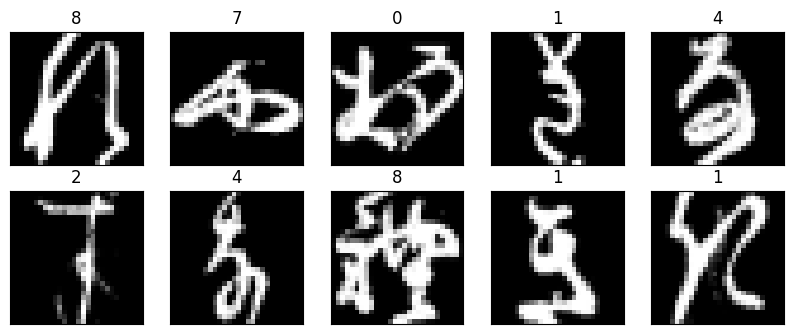

In [12]:
plt.figure(figsize=(10,10))
for i in range(10):  
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])
plt.show() 

# Preprocesamiento de los datos

In [7]:
# Los datos vienen en formato (28,28) pero keras necesita (28,28,1)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Se normaliza el valor de los pixeles para que estén entre 0 y 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('{} train samples, {} test samples'.format(len(x_train), len(x_test)))

60000 train samples, 10000 test samples


# Definición de la red neuronal
Luego de estudiar 2 de las arquitecturas de redes convolucionales más populares, AlexNet y LeNet, decidimos compararlas para adquirir más conocimiento antes de diseñar una red propia, ya que estas son arquitecturas aceptadas por la comunidad científica.

## AlexNet
Debido a que la arquitectura de AlexNet está pensada para imágenes de 227x227 con 3 canales de colores, y el dataset KMNIST es de 28x28 con solo 1 canal, decidimos adaptarla a nuestro dataset reduciendo el número de filtros y neuronas de procesamiento, pero manteniendo el esquema principal.

### Referencias:
https://www.analyticsvidhya.com/blog/2021/03/introduction-to-the-architecture-of-alexnet/?utm_source=reading_list&utm_medium=https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/

In [410]:
alex_net = models.Sequential()
alex_net.add(layers.Conv2D(48, (5, 5), activation="relu", input_shape=input_shape))
alex_net.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
alex_net.add(layers.Conv2D(128, (4, 4), padding="same", activation="relu"))
alex_net.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
alex_net.add(layers.Conv2D(192, (3, 3), padding="same", activation="relu"))
alex_net.add(layers.Conv2D(192, (3, 3), padding="same", activation="relu"))
alex_net.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu"))
alex_net.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
alex_net.add(layers.Flatten())
alex_net.add(layers.Dropout(0.5))
alex_net.add(layers.Dense(512, activation="relu"))
alex_net.add(layers.Dropout(0.5))
alex_net.add(layers.Dense(512, activation="relu"))
alex_net.add(layers.Dense(10, activation="softmax"))
alex_net.summary()

Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_361 (Conv2D)         (None, 24, 24, 48)        1248      
                                                                 
 max_pooling2d_221 (MaxPool  (None, 12, 12, 48)        0         
 ing2D)                                                          
                                                                 
 conv2d_362 (Conv2D)         (None, 12, 12, 128)       98432     
                                                                 
 max_pooling2d_222 (MaxPool  (None, 6, 6, 128)         0         
 ing2D)                                                          
                                                                 
 conv2d_363 (Conv2D)         (None, 6, 6, 192)         221376    
                                                                 
 conv2d_364 (Conv2D)         (None, 6, 6, 192)      

## LeNet
Por otro lado, la arquitectura de LeNet 5 está pensada para imágenes de 32x32 con 1 canal de color, , el cual es simular al de 28x28 con 1 canal de color de las imagenes de KMNIST, por lo que el único cambio que se realizo fue el de utilizar un kernel de 3x3 en la capa convolucional de 120 filtros en vez de 5x5, lo cual generaba un error por la dimensión de las imágenes de entrada.

### Referencias
https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/?utm_source=reading_list&utm_medium=https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/

In [47]:
le_net = models.Sequential()
le_net.add(layers.Conv2D(6, (5, 5), activation="tanh", input_shape=input_shape))
le_net.add(layers.AveragePooling2D((2, 2), strides=2))
le_net.add(layers.Conv2D(16, (5, 5), activation="tanh"))
le_net.add(layers.AveragePooling2D((2, 2), strides=2))
le_net.add(layers.Conv2D(120, (3, 3), activation="tanh"))
le_net.add(layers.Flatten())
le_net.add(layers.Dense(84, activation="tanh"))
le_net.add(layers.Dense(10, activation="softmax"))
le_net.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d_12 (Aver  (None, 12, 12, 6)         0         
 agePooling2D)                                                   
                                                                 
 conv2d_64 (Conv2D)          (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_13 (Aver  (None, 4, 4, 16)          0         
 agePooling2D)                                                   
                                                                 
 conv2d_65 (Conv2D)          (None, 2, 2, 120)         17400     
                                                                 
 flatten_15 (Flatten)        (None, 480)             

# Entrenamiento de la red neuronal

In [412]:
alex_net.compile(
    optimizer="adam",
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

history_alex = alex_net.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 54s 29ms/step - loss: 0.3278 - accuracy: 0.8951 - val_loss: 0.2460 - val_accuracy: 0.9279
Epoch 2/5
1875/1875 [==============================] - 200s 107ms/step - loss: 0.0984 - accuracy: 0.9728 - val_loss: 0.1906 - val_accuracy: 0.9511
Epoch 3/5
1875/1875 [==============================] - 670s 357ms/step - loss: 0.0789 - accuracy: 0.9783 - val_loss: 0.2380 - val_accuracy: 0.9387
Epoch 4/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0633 - accuracy: 0.9830 - val_loss: 0.1864 - val_accuracy: 0.9536
Epoch 5/5
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0562 - accuracy: 0.9853 - val_loss: 0.2080 - val_accuracy: 0.9505


In [48]:
le_net.compile(
    optimizer="adam",
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

history_lenet = le_net.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4567 - accuracy: 0.8630 - val_loss: 0.5846 - val_accuracy: 0.8198
Epoch 2/5
1875/1875 [==============================] - 8s 5ms/step - loss: 0.2037 - accuracy: 0.9390 - val_loss: 0.4367 - val_accuracy: 0.8671
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1487 - accuracy: 0.9560 - val_loss: 0.3648 - val_accuracy: 0.8934
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1138 - accuracy: 0.9654 - val_loss: 0.3388 - val_accuracy: 0.9035
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0974 - accuracy: 0.9708 - val_loss: 0.3446 - val_accuracy: 0.9004


313/313 - 3s - loss: 0.2080 - accuracy: 0.9505 - 3s/epoch - 8ms/step


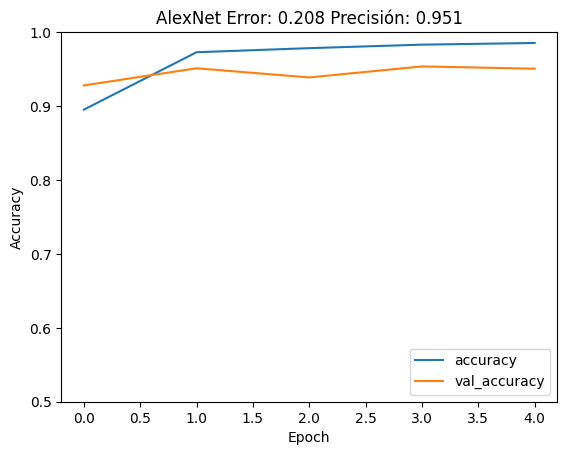

313/313 - 0s - loss: 0.3326 - accuracy: 0.9089 - 455ms/epoch - 1ms/step


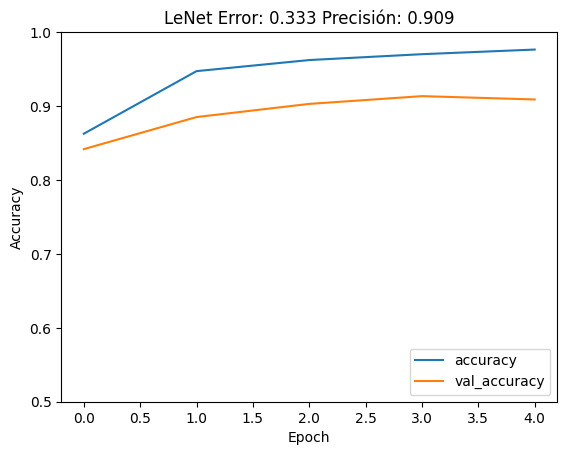

In [414]:
test_loss, test_acc = alex_net.evaluate(x_test, y_test, verbose=2)
plt.plot(history_alex.history["accuracy"], label="accuracy")
plt.plot(history_alex.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")
plt.title(
    "AlexNet Error: {} Precisión: {}".format(round(test_loss, 3), round(test_acc, 3))
)
plt.show()

test_loss, test_acc = le_net.evaluate(x_test, y_test, verbose=2)
plt.plot(history_lenet.history["accuracy"], label="accuracy")
plt.plot(history_lenet.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")
plt.title(
    "LeNet Error: {} Precisión: {}".format(round(test_loss, 3), round(test_acc, 3))
)
plt.show()

# Conclusiones de la comparación:

1. La adaptación de AlexNet alcanza una precisión mayor debido a que es más profunda que LeNet, por lo que puede extraer más características de las imágenes.

2. La diferencia de precisión entre ambas arquitecturas es muy pequeña, debido a que el dataset KMNIST es una prueba sencilla, en un dataset más grande y con imágenes más complejas y con más clasificaciones posibles, se debería apreciar una diferencia mucho mayor.

3. El tiempo de entrenamiento de AlexNet es aproximadamente 5 veces el de LeNet para este dataset, lo cual no concuerda con la diferencia en la precisión, por lo que para conjuntos de imágenes pequeñas y sencillas, es más recomendable LeNet.

# Definición de la red neuronal propia
En base a lo observado en las arquitecturas anteriores, se decidió diseñar una red propia.
Se decidió utilizar la técnica de Hyperparameter Tuning para encontrar los mejores parámetros para la red neuronal en cuanto a número de filtros, tamaño de kernel y padding de cada capa convolucional.
Luego de varias pruebas, se optó por la siguiente arquitectura, la cual dio los mejores resultados:
1. Una capa convolucional para extraer características generales de las imágenes.
2. Un max pooling para reducir la dimensionalidad de las imágenes preservando las características específicas.
3. 2 capas convolucionales para extraer características más específicas de las imágenes.
4. Un average pooling para reducir la dimensionalidad de las imágenes preservando las características generales.
5. Aplanamiento y capas densas de salida para clasificar las imágenes.

Para el entrenamiento de la red neuronal recurrente utilizaremos como loss la función 'sparse_categorical_crossentropy' porque al ser un problema de clasificación multiclase esta nos permite calcular la pérdida entre la etiqueta y la predicción. 
Además, utilizamos el optimizador 'adam' porque es un optimizador que se usa comunmente en las CNN ya que usa una tasa de aprendizaje adaptativa por lo que maneja bien la variabilidad de los mapas de características y se ha demostrado que evita el desvanecimiento de gradiente y el overfitting, gracias a que propaga los gradientes en múltiples capas e implementa un efecto de regularizacion L2.

In [13]:
class Model(HyperModel):
    def build(self, hp):
        model = models.Sequential()
        model.add(
            layers.Conv2D(
                hp.Int("filters", 32, 64, step=16),
                hp.Int("kernel", 3, 7, step=2),
                activation="relu",
                padding=hp.Choice("padding", ["same", "valid"]),
                input_shape=input_shape,
            )
        )
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
        model.add(
            layers.Conv2D(
                hp.Int("filters_2", 48, 96, step=16),
                hp.Choice("kernel_2", [3, 5]),
                activation="relu",
                padding=hp.Choice("padding", ["same", "valid"]),
            )
        )
        model.add(
            layers.Conv2D(
                hp.Int("filters_3", 48, 96, step=16),
                hp.Choice("kernel_3", [3, 5]),
                activation="relu",
                padding=hp.Choice("padding", ["same", "valid"]),
            ),
        ),
        model.add(layers.AveragePooling2D((2, 2), strides=(2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dropout(hp.Choice("dropout", [0.2, 0.3, 0.4, 0.5])))
        model.add(
            layers.Dense(
                hp.Choice("dense", [64, 96, 128]),
                activation="relu",
            )
        )
        model.add(layers.Dense(10, activation="softmax"))
        model.compile(
            optimizer="adam",
            loss=losses.SparseCategoricalCrossentropy(),
            metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            shuffle=hp.Boolean("shuffle"),
            **kwargs,
        )

# Entrenamiento de la red neuronal propia

In [20]:
model = Model()
tuner = RandomSearch(model, objective="val_accuracy", max_trials=5)
tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
best_model = tuner.get_best_models()[0]
best_model.build(input_shape=(None, 28, 28))
best_model.summary()
tuner.results_summary()
rmtree("untitled_project")

Trial 5 Complete [00h 06m 17s]
val_accuracy: 0.9660999774932861

Best val_accuracy So Far: 0.9660999774932861
Total elapsed time: 00h 16m 38s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 48)        1248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 48)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        76864     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 96)        55392     
                                                                 
 average_pooling2d (Average  (None, 7, 7, 96)          0         
 Pooling2D)                                   

In [21]:
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=2)

313/313 - 3s - loss: 0.1528 - accuracy: 0.9661 - 3s/epoch - 9ms/step


# Conclusiones generales

La red implementada logra superar ligeramente la precisión de AlexNet, con un tiempo de entrenamiento mucho menor, a continuación se presentan unas conclusiones de lo observado durante el proyecto:

1. Por lo general, se acostumbra que la capa convolucional de input tenga una cantidad baja de filtros y un kernel más grande, y que las capas convolucionales posteriores tengan más filtros y un kernel más pequeño, esto se debe a que la primera capa convolucional se encarga de extraer características generales de la imagen, mientras que las siguientes capas se encargan de extraer características cada vez más específicas.

2. Anidar capas convolucionales sin capas de pooling entre ellas, puede aumentar la precisión del modelo al recoger más detalles de la imagen, pero aumenta el tiempo de entrenamiento, y puede generar overfitting.

3. El uso de capas de dropout luego de las capas convolucionales, puede remover detalles innecesarios de las imágenes, en este caso aumenta ligeramente la precisión, además puede prevenir el overfitting, pero hay riesgo de perder detalles importantes y en consecuencia bajar la precisión.

4. El average pooling guarda información más general de las imágenes, como patrones y relaciones de espacio, mientras que el max pooling guarda información más específica, como bordes u objetos. En las arquitecturas mas modernas es predominante el max pooling, sin embargo algunas combinan ambos tipos de pooling. En este caso se obtuvo una mayor precisión combinando ambos tipos de pooling o usando 2 tipos iguales de pooling.